# IMAGE COLORIZATION USING cGAN

**Contents**

1. [Import Packages](#packages)
2. [Utils](#utils)
3. [Data preparation](#dataset)
4. [Image Colorization and Color Science Computation](#4-image-colorization-and-color-science-computations)
5. [Generator architecture](#generator)
6. [Discriminator architecture](#discriminator)
7. [Trainer](#training)
8. [Validation](#validation)

## 1. Import Packages <a class="anchor" id="packages"></a>

In [1]:
# Operating system and file operations
import os

# Numerical operations and array processing
import numpy as np

# Data visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Random number generation
import random

# Image processing and computer vision
import cv2

# Deep learning and neural networks
import torch
import torch.nn as nn
import torch.nn.functional as F

# Data handling for deep learning
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

# Displaying model information
from torchsummary import summary

# Image manipulation
from PIL import Image

# Type annotations
from typing import List

# Progress bar for Jupyter Notebooks
from tqdm.notebook import tqdm

# Color space conversions
from colour import sRGB_to_XYZ, XYZ_to_Lab, Lab_to_XYZ, XYZ_to_sRGB

# Image quality assessment
from skimage.metrics import structural_similarity as ssim

# Memory management
import gc

# Handling warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## 2. Utils <a class="anchor" id="utils"></a>

In [ ]:
# Determine the device to use for PyTorch operations
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Print the selected device which device will be used for PyTorch operations.
print(device)

cpu


=======================================================================

## 3. Data Preparation

The data preparation process is a crucial step in ensuring the quality and effectiveness of the image colorization model.

#### Dataset Description
- **Total Images**: 64 images.
- **Image Formats**: Each image is available in two versions: grayscale and color.
- **Image Resolution**: The images have been processed to a consistent resolution, suitable for model processing.

#### Data Split
The dataset has been divided into two main subsets for training and testing the model:
- **Training Data**: 80% of the total images (51 images) are used for model training. The training data includes a mix of grayscale and color images, allowing the model to learn to recognize and reproduce colors from grayscale images.
- **Testing Data**: 20% of the total images (13 images) are used as a test set to evaluate the model's performance. Testing ensures that the model can generalize what it has learned to new, unseen images.

=======================================================================

## 4. Image Colorization and Color Science Computations

In [ ]:
def lab_to_rgb(L, ab, device):
    """
    Takes a batch of images
    """
    L = 100 * L  # Scale the L component from 0-1 to 0-100
    ab = (ab - 0.5) * 256  # Adjust the a and b components to the correct range
    Lab = torch.cat([L, ab], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()  # Combine L, a, b, and rearrange the format for processing
    rgb_imgs = []  # Initialize a list to store the resulting RGB images
    for img in Lab:
        img = Lab_to_XYZ(img)  # Convert LAB to XYZ
        img = XYZ_to_sRGB(img)  # Convert XYZ to RGB
        rgb_imgs.append(img)  # Append the RGB image to the list
    return torch.tensor(np.stack(rgb_imgs, axis=0)).permute(0, 3, 1, 2).to(device)  # Return the images as a PyTorch tensor and move to the specified device

In [ ]:
# Set the desired image size
image_size = (3600, 1440)

# Compose a series of transformations to be applied to the images
t = transforms.Compose([
    transforms.Resize(image_size, antialias=True),  # Resize the image with antialias to reduce distortion
    transforms.Normalize(mean=0, std=0.5)           # Normalize the images to facilitate neural network processing
])

In [ ]:
class ImageColorizeDataset(Dataset):
    def __init__(self, path: str, device='cpu', train: bool = False, transforms = None):
        # Set the dataset mode based on the train argument, 'train' for training and 'test' for testing
        _mode = 'train' if train else 'test'
        
        self.device = device  # Device where data will be processed (CPU or GPU)
        self._input_path = os.path.join(path, f'{_mode}_color')  # Path to the data
        
        self.data = os.listdir(self._input_path)  # List all image files in the directory
        
        self.transforms = transforms  # Transformations to be applied to the images

    def __len__(self):
        return len(self.data)  # Return the number of data in the dataset

    def __getitem__(self, idx: int):
        to_tensor = transforms.ToTensor()  # Transform the image to a tensor
        
        item = self.data[idx]  # Retrieve the data item by index
        
        input_ = Image.open(os.path.join(self._input_path, item))  # Open image
        w, h = input_.size  # Get image dimensions
        left = 0
        top = 0
        right = w
        bottom = h / 2  # Take the top half of the image
        input_ = input_.crop((left, top, right, bottom))  # Crop the image
        
        input_ = to_tensor(input_)  # Convert the cropped image to a tensor
        
        # Set seed for reproducibility
        seed = np.random.randint(2147483647)
        random.seed(seed)
        torch.manual_seed(seed)
        if self.transforms is not None:
            input_ = self.transforms(input_)  # Apply transformations if any
        
        img = input_.permute(1, 2, 0).numpy()  # Rearrange axes for color space conversion
        img = sRGB_to_XYZ(img)  # Convert sRGB to XYZ
        img = XYZ_to_Lab(img).transpose(2, 0, 1).astype("float32")  # Convert XYZ to LAB
        
        L = torch.tensor(img[[0], ...] / 100)  # Normalize the L component
        ab = torch.tensor(img[[1, 2], ...] / 256 + 0.5)  # Normalize the a and b components
        
        return L.to(device), ab.to(device)  # Return as tensor and send to the specified device

In [ ]:
def tensor_to_image(tensor):
        tensor = tensor.cpu().detach()
        tensor = tensor.permute(1, 2, 0).numpy()  # Convert to HWC format
        tensor = (tensor * 255).astype(np.uint8)  # Rescale to 0-255 and convert to uint8
        return Image.fromarray(tensor)

In [ ]:
# Initialize the dataset for testing with specified transformations and not in training mode
test_data = ImageColorizeDataset("dataset1", 
								 transforms=t, train=False)
# DataLoader for the test dataset, with a batch size of 8 and shuffling enabled
test_dl = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
# Initialize the dataset for training with specified transformations and in training mode
train_data = ImageColorizeDataset("dataset1", 
								  transforms=t, train=True)
# DataLoader for the training dataset, with a batch size of 8 and shuffling enabled
train_dl = DataLoader(train_data, batch_size=1, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


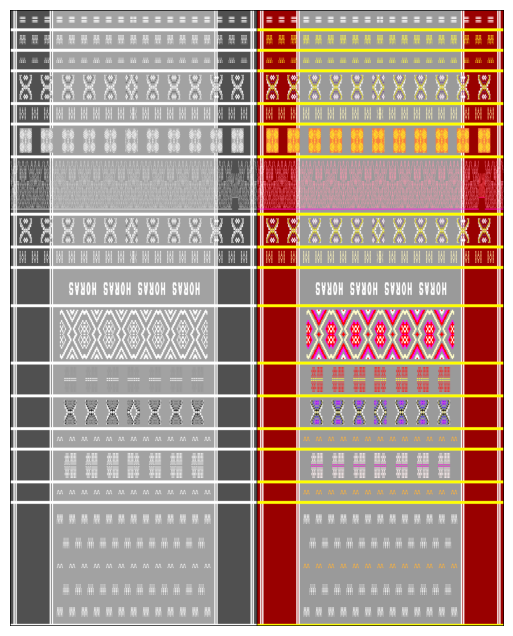

<Figure size 640x480 with 0 Axes>

In [ ]:
# Retrieve the next batch of images and targets from the training DataLoader
images, targets = next(iter(train_dl))

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# to_show = lab_to_rgb(images, targets, device=device)

# # Display each image without using grid or plot
# for i, img in enumerate(to_show):
#     image = tensor_to_image(img)
#     image.show(title=f"Image {i+1}")
#     image.save(f"output_image_{i+1}.png")  # Save the image if needed


# Kode yang baru dibuat 
# Convert LAB images back to RGB using the lab_to_rgb function for visualization
to_show = lab_to_rgb(images, targets, device=device)

# Create a grid of images combining the original and colorized images for display
grid = torchvision.utils.make_grid(
    torch.cat([images.expand(to_show.shape), to_show], dim=0),  # Concatenate original and colorized images
    nrow=8,          # Number of images per row
    padding=4,       # Space between images
    scale_each=True, # Scale images individually
    border=2         # Border size around images
)

# Plot the grid of images using matplotlib
fig = plt.figure(figsize=(16,8))  # Set the figure size
plt.imshow(grid.cpu().permute(1,2,0))  # Convert tensor to numpy array and display as image
plt.axis('off')  # Hide axes
plt.show()  # Display the plot
plt.savefig('gambar.jpg')  # Save the plot as an image

## 5. Generator <a class="anchor" id="generator"></a>

UNet model was used as a generator. It takes image as an input. To randomize output of generator, dropout layers applied both at training and evalutaion time as a noise.

#### Convolutional Block with Residual Connection

The `ConvBlock` class extends `nn.Module` and implements a convolutional block with a residual connection, typically used in modern deep learning architectures like ResNets.

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, norm_layer=nn.BatchNorm2d):
        super().__init__()
        # Defines a sequential container for two convolutional blocks with BatchNorm and ReLU activation
        self.block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            norm_layer(out_channels),  # Normalization layer, here using BatchNorm
            nn.ReLU(inplace=True),     # ReLU activation with in-place operation to save memory
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, stride=1, bias=False),
            norm_layer(out_channels),  # Second normalization layer
            nn.ReLU(inplace=True)      # Second ReLU activation
        )
        
        # Identity mapping that may be used to match dimensions for the residual connection
        self.identity = nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False)
        self.relu = nn.ReLU(inplace=True)  # Final ReLU activation after adding the residual
        
    def forward(self, x):
        x_ = x.detach().clone()  # Detach and clone the input to prevent modifications during forwarding
        x_ = self.block(x_)       # Pass the input through the convolutional block
        
        residual = self.identity(x)  # Apply the identity mapping to the original input
        
        out = x_ + residual          # Add the output of the convolutional block to the identity mapping
        
        return self.relu(out)        # Apply a ReLU activation to the combined output and return it

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, sampling_factor=2):
        super().__init__()
        # Sequential container for an encoder block that includes a max pooling followed by a convolutional block
        self.block = nn.Sequential(
            nn.MaxPool2d(sampling_factor),  # Reduces the spatial dimensions of the input
            ConvBlock(in_chans, out_chans) # Applies a convolutional block to further process the data
        )
        
    def forward(self, x):
        # Forward pass of the encoder block: applies pooling and then convolution
        return self.block(x)
    
class DecoderBlock(nn.Module):
    def __init__(self, in_chans, out_chans, sampling_factor=2):
        super().__init__()
        # Upsampling layer to increase the spatial dimensions of the input
        self.upsample = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        
        # Convolutional block that processes the concatenated input from the upsampled feature map and the skip connection
        self.block = ConvBlock(in_chans + out_chans, out_chans)
        
    def forward(self, x, skip):
        # Upsamples the input feature map
        x = self.upsample(x)
        # Concatenates the upsampled feature map with the skip connection feature map
        x = torch.cat([x, skip], dim=1)
        # Processes the concatenated feature maps using a convolutional block
        x = self.block(x)
        return x

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2, dropout_rate=0.2):
        super().__init__()
        # Initialize the encoder part of the U-Net with progressively increasing channels
        self.encoder = nn.ModuleList([
            ConvBlock(in_channels, 64),
            EncoderBlock(64, 128),
            EncoderBlock(128, 256),
            EncoderBlock(256, 512),
        ])
        # Initialize the decoder part of the U-Net with progressively decreasing channels
        self.decoder = nn.ModuleList([
            DecoderBlock(512, 256),
            DecoderBlock(256, 128),
            DecoderBlock(128, 64)
        ])
        # Dropout layer to prevent overfitting
        self.dropout = nn.Dropout2d(dropout_rate)
        # Final convolution layer to map the decoded features to the desired number of output channels
        self.logits = nn.Conv2d(in_channels=64, out_channels=out_channels, kernel_size=1)
    
    def forward(self, x):
        encoded = []
        # Pass input through each encoder block, apply dropout, and store intermediate outputs for skip connections
        for enc in self.encoder:
            x = enc(x)
            x = self.dropout(x)
            encoded.append(x)

        enc_out = encoded.pop()
        
        # Start the decoding process using the stored encoded features
        for dec in self.decoder:
            enc_out = encoded.pop()  # Retrieve the corresponding encoder output for skip connections
            x = dec(x, enc_out)  # Decoder block processes input with skip connections
        # Apply a sigmoid activation to the final layer's output to normalize the output to [0,1] range
        return F.sigmoid(self.logits(x))

In [ ]:
# Trigger the garbage collector to free memory from unreferenced objects.
gc.collect()

10

## 4. Discriminator <a class="anchor" id="discriminator"></a>

Due to our input image shape `batch_size x 3 x 256 x 128`, in out PatchGAN discriminator we have 3 sequential `3 x 3` conv

In [ ]:
class PatchGAN(nn.Module):
    def __init__(self, in_channels, n_features=64, n_layers=3):
        super().__init__()
        # Initialize the PatchGAN architecture parameters
        k_size = 4  # kernel size
        p_size = 2  # padding size
        
        # Starting layer configuration with a convolutional layer and a LeakyReLU activation
        seq = [
            nn.Conv2d(in_channels=in_channels, out_channels=n_features, kernel_size=k_size, padding=p_size, stride=2),
            nn.LeakyReLU(0.2, True)
        ]
        
        # Factor multipliers for feature map scaling in subsequent layers
        f_mult = 1
        f_mult_prev = 1
        
        # Construct additional convolutional layers as specified by n_layers
        for i in range(1, n_layers):
            f_mult_prev = f_mult
            f_mult = min(2 ** i, 8)  # Update feature multiplier with constraints
            
            seq.append(nn.Conv2d(in_channels=f_mult_prev * n_features, out_channels=f_mult * n_features, kernel_size=k_size, padding=p_size, stride=2))
            seq.append(nn.BatchNorm2d(f_mult * n_features))  # Batch normalization for stability
            seq.append(nn.LeakyReLU(0.2, True))  # LeakyReLU for non-linear processing

        # Last convolutional layers before the final output layer
        f_mult_prev = f_mult
        f_mult = min(2 ** n_layers, 8)
        
        seq += [
            nn.Conv2d(n_features * f_mult_prev, n_features * f_mult, kernel_size=k_size, stride=1, padding=p_size),
            nn.BatchNorm2d(n_features * f_mult),
            nn.LeakyReLU(0.2, True)
        ]

        # Final convolutional layer to produce a 1-channel prediction map
        seq += [nn.Conv2d(n_features * f_mult, 1, kernel_size=k_size, stride=1, padding=p_size)]
        self.model = nn.Sequential(*seq)

    def forward(self, x, label):
        # Concatenate input and label along the channel dimension for conditional GAN processing
        x = torch.cat((x, label), dim=1)
        x = self.model(x)  # Pass through the network
        return x

In [ ]:
D = PatchGAN(in_channels=3).to(device)  # Initialize the PatchGAN discriminator

# Display the model architecture
summary(D, [(1, image_size[0], image_size[1]), (2, image_size[0], image_size[1])])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1        [-1, 64, 1801, 721]           3,136
         LeakyReLU-2        [-1, 64, 1801, 721]               0
            Conv2d-3        [-1, 128, 901, 361]         131,200
       BatchNorm2d-4        [-1, 128, 901, 361]             256
         LeakyReLU-5        [-1, 128, 901, 361]               0
            Conv2d-6        [-1, 256, 451, 181]         524,544
       BatchNorm2d-7        [-1, 256, 451, 181]             512
         LeakyReLU-8        [-1, 256, 451, 181]               0
            Conv2d-9        [-1, 512, 452, 182]       2,097,664
      BatchNorm2d-10        [-1, 512, 452, 182]           1,024
        LeakyReLU-11        [-1, 512, 452, 182]               0
           Conv2d-12          [-1, 1, 453, 183]           8,193
Total params: 2,766,529
Trainable params: 2,766,529
Non-trainable params: 0
---------------------------

In [ ]:
G = UNet(in_channels=1, out_channels=2).to(device)
# G2 = UNet(in_channels=2, out_channels=1).to(device)

# summary(G, (1, 384, 384))
summary(G, (1, image_size[0], image_size[1]))

## 5. Trainer <a class="anchor" id="training"></a>

In [ ]:
class Trainer: 
    def __init__(self, G, D, device, batch_size = 32, lr=1e-3, discriminator_to_generator_training_rate = 2, plot_rate=1):
        
        self.G = G
        self.D = D
        
        self.L1_G_loss = nn.L1Loss()
        self.G_loss = nn.BCEWithLogitsLoss()
        self.D_loss = nn.BCEWithLogitsLoss()
        
        self.G_optim = torch.optim.Adam(params=G.parameters(), lr=1-e4)
        self.D_optim = torch.optim.Adam(params=D.parameters(), lr=4-e4)

        
        self.batch_size = batch_size
        
        self.loss_G_per_epoch = []
        self.loss_D_per_epoch = []
        self.loss_D_real_per_epoch = []
        self.loss_D_fake_per_epoch = []
        
        self.loss_G_history = []
        self.loss_D_history = []
        self.loss_D_real_history = []
        self.loss_D_fake_history = []
        
        self.k = discriminator_to_generator_training_rate
        self.device = device
        
        self.plot_rate = plot_rate
    
    def train(self, dataloader, epoch):
        for epoch in range(epoch):
            self.loss_G_history.append([])
            self.loss_D_history.append([])
            self.loss_D_real_history.append([])
            self.loss_D_fake_history.append([])
            
            print(f'EPOCH: {epoch + 1}')
            for i, (images, targets) in enumerate(tqdm(dataloader)):
                self._train_discriminator(images, targets)
                
                if (i + 1) % self.k == 0:
                    self._train_generator(images, targets)
    
            self.loss_G_per_epoch.append(np.mean(self.loss_G_history[-1]))
            self.loss_D_per_epoch.append(np.mean(self.loss_D_history[-1]))
            self.loss_D_real_per_epoch.append(np.mean(self.loss_D_real_history[-1]))
            self.loss_D_fake_per_epoch.append(np.mean(self.loss_D_fake_history[-1]))
            
            if (epoch + 1) % self.plot_rate == 0:
                self._plot_epoch_stats(epoch)
                self._plot_fake_images(images, targets)
            self._plot_stats

    
    def _train_generator(self, inputs, targets):
        
        self.G_optim.zero_grad()
        
        self.G.train()
        self.D.eval()
        
        l = 1
        
        fake_targets = self.G(inputs)
        
        predictions = self.D(inputs, fake_targets)
        fake_labels = torch.zeros(*predictions.shape,  device=self.device)
        
        L1_loss = self.L1_G_loss(fake_targets, targets)
        BCE_loss = self.G_loss(predictions, fake_labels)
        loss_g = BCE_loss + l * L1_loss
        self.loss_G_history[-1].append(loss_g.item())
        loss_g.backward()
        self.G_optim.step()
                
    
    def _train_discriminator(self, inputs, real_targets):
        self.D_optim.zero_grad()
        
        self.G.eval()
        self.D.train()
        
        # train on real images
        
        real_predictions = self.D(inputs, real_targets)
        real_label = torch.ones(*real_predictions.shape,  device=self.device)

        real = self.D_loss(real_predictions, real_label)
        
        
        # train on fake images
                
        fake_targets = self.G(inputs)
        fake_predictions = self.D(inputs, fake_targets.detach())
        fake_label = torch.zeros(*fake_predictions.shape, device=self.device)

        fake = self.D_loss(fake_predictions, fake_label)
        
        loss_d = real + fake
        
        self.loss_D_history[-1].append(loss_d.item())
        self.loss_D_real_history[-1].append(real.item())
        self.loss_D_fake_history[-1].append(fake.item())

        loss_d.backward()
        self.D_optim.step()
        
    def _plot_fake_images(self, images, targets, nrow=8):
        """
        Showing the generator's results
        """
        
        self.G.eval()
                
        fake = self.G(images)
        
        to_show = lab_to_rgb(images, fake, device=self.device)
        to_show_real = lab_to_rgb(images, targets, device=self.device)

        # Calculate SSIM
        score_ssim = calculate_ssim(images, fake, targets)
        print(f"SSIM: {score_ssim}")

        # Calculate Colourfulness
        score_colourfulness = calculate_colourfulness(images, fake)
        print(f"Colourfulness: {score_colourfulness}")

        a = fake[:, 0, :, :].unsqueeze(1).expand(to_show.shape)
        b = fake[:, 1, :, :].unsqueeze(1).expand(to_show.shape)
        grid = torchvision.utils.make_grid(torch.cat([images.expand(to_show.shape), a, b, to_show, to_show_real], dim=0), nrow=8, padding=1, scale_each=True)

        fig = plt.figure(figsize=(16,8))
        plt.imshow(grid.cpu().permute(1,2,0))
        plt.axis('off')
        plt.show()
        
    def _plot_stats(self):
        """
        Plotting stats of history training
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 4))
        sns.lineplot(self.loss_D_per_epoch, label="discriminator", ax=axes[0][0])
        sns.lineplot(self.loss_G_per_epoch, label="generator", ax=axes[0][1])
        
        sns.lineplot(self.loss_D_real_per_epoch, label="real", ax=axes[1][0])
        sns.lineplot(self.loss_D_fake_per_epoch, label="fake", ax=axes[1][1])
        
        plt.tight_layout()
        plt.show()

        
    def _plot_epoch_stats(self, epoch):
        """
        Plotting stats of history training
        """
        fig, axes = plt.subplots(2, 2, figsize=(10, 4))
        sns.lineplot(self.loss_D_history[epoch], label="discriminator", ax=axes[0][0])
        sns.lineplot(self.loss_G_history[epoch], label="generator", ax=axes[0][1])
        
        sns.lineplot(self.loss_D_real_history[epoch], label="real", ax=axes[1][0])
        sns.lineplot(self.loss_D_fake_history[epoch], label="fake", ax=axes[1][1])
        
        plt.tight_layout()
        plt.show()
        
    def _plot_losses(self):
        """
        Plot the generator and discriminator losses per epoch.
        """
        epochs = range(1, len(self.loss_G_per_epoch) + 1)

        plt.figure(figsize=(8, 5))
        plt.plot(epochs, self.loss_G_per_epoch, label='Generator loss', color='blue')
        plt.plot(epochs, self.loss_D_per_epoch, label='Discriminator loss', color='red')
        plt.title('Loss vs. Epoch')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

## 7. Validation

In [ ]:
def calculate_ssim(L, ab_gen, ab_gt):
    """
    Calculate the Structural Similarity Index (SSIM)
    """
    L = 100 * L # Scale the L component from 0-1 to 0-100
    ab_gen = (ab_gen - 0.5) * 256 # Adjust the a and b components to the correct range
    ab_gt = (ab_gt - 0.5) * 256 # Adjust the a and b components to the correct range

    Lab_gens = torch.cat([L, ab_gen], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy() # Combine L, a, b, and rearrange the format for processing
    Lab_gts = torch.cat([L, ab_gt], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()   # Combine L, a, b, and rearrange the format for processing
    
    scores = [] # Initialize a list to store the SSIM scores
    for img_gen, img_gt in zip(Lab_gens, Lab_gts):  # Iterate over the generated and ground truth images
        img_gen = Lab_to_XYZ(img_gen)   # Convert LAB to XYZ
        img_gen = XYZ_to_sRGB(img_gen)  # Convert XYZ to sRGB
        
        img_gt = Lab_to_XYZ(img_gt)    # Convert LAB to XYZ
        img_gt = XYZ_to_sRGB(img_gt)    # Convert XYZ to sRGB
        
        scores.append(ssim(img_gen, img_gt, channel_axis=-1, data_range=255)) # Calculate the SSIM score
    
    return round(np.mean(scores), 4)    # Return the mean SSIM score

def calculate_colourfulness(L, ab_gen): 
    """
    Calculate the Colourfulness.
    References
    ----------
    D. Hasler and S.E.Suesstrunk, ``Measuring colorfulness in natural images," Human
    Vision andElectronicImagingVIII, Proceedings of the SPIE, 5007:87-95, 2003.
    ----------
    """
    L = 100 * L     # Scale the L component from 0-1 to 0-100
    ab_gen = (ab_gen - 0.5) * 256   # Adjust the a and b components to the correct range

    Lab_gens = torch.cat([L, ab_gen], dim=1).permute(0, 2, 3, 1).detach().cpu().numpy()     # Combine L, a, b, and rearrange the format for processing
    
    scores = []     # Initialize a list to store the colourfulness scores
    for img_gen in Lab_gens:   # Iterate over the generated images
        img_gen = Lab_to_XYZ(img_gen)  # Convert LAB to XYZ
        img_gen = XYZ_to_sRGB(img_gen)  # Convert XYZ to sRGB
        
        rg = img_gen[:, 0] - img_gen[:, 1] # Calculate the red-green channel
        yb = 0.5 * (img_gen[:, 0] + img_gen[:, 1]) - img_gen[:, 2] # Calculate the yellow-blue channel

        mean_rgyb = np.sqrt(np.mean(rg) ** 2 + np.mean(yb) ** 2) # Calculate the mean of the RG and YB channels
        std_rgyb = np.sqrt(np.std(rg) ** 2 + np.std(yb) ** 2)   # Calculate the standard deviation of the RG and YB channels

        scores.append(std_rgyb + 0.3 * mean_rgyb) # Calculate the colourfulness score
    
    return round(np.mean(scores), 4)    # Return the mean colourfulness score

In [ ]:
trainer = Trainer(G, D, device) # Initialize the trainer with the generator and discriminator

In [ ]:
# Train the models for 50 epochs
# trainer.train(train_dl, epoch=50) 	
trainer.train(train_dl, epoch=5) 	

# trainer.train(train_dl, epoch=1) 	

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming loss_G_per_epoch and loss_D_per_epoch are already populated during training

# Example data for illustration (replace with actual data)
epochs = list(range(1, 81))
ssim_values = [calculate_ssim(images, fake, targets) for epoch in epochs]  # Placeholder function
colorfulness_values = [calculate_colourfulness(images, fake) for epoch in epochs]  # Placeholder function

# Plotting SSIM over epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, ssim_values, label='SSIM')
plt.xlabel('Epoch')
plt.ylabel('SSIM')
plt.title('SSIM vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()

# Plotting Colorfulness over epochs
plt.figure(figsize=(12, 6))
plt.plot(epochs, colorfulness_values, label='Colorfulness', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Colorfulness')
plt.title('Colorfulness vs. Epoch')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
trainer._plot_losses() 	# Plot the generator and discriminator losses per epoch

In [ ]:
trainer.G	# Set the generator to evaluation mode